# Recursive Competitive Equilibria

Contents:

- [Recursive Competitive Equilibria](#Recursive-Competitive-Equilibria)  
  - [Stochastic Growth Model](#Stochastic-Growth-Model) 
  - [Transition Equations](#Transition-Equations) 
  - [Steady State](#Steady-State)   
  - [Policy Functions](#Policy-Functions)   
  - [Simulations](#Simulations)

This lab includes:

(1) An overview of a basic stochastic growth model;

(2) Finding the transition equations of the model using dynamic programming;

(3) Solving for the policy functions of the model using value function iteration;

(4) Solving for the price system of the economy;

(5) Simulating the equilibrium paths of the economy under various initial conditions.

Load all necessary packages:

In [1]:
using Statistics, Plots, LinearAlgebra, Roots, QuantEcon, LaTeXStrings

---

## Stochastic Growth Model

### Refresher

Just to remind you of the nature of the model:

- The economy is populated by a **household** that consumes a good, sells labor, and trades claims to date $t+1$ consumption.

- On the production side, there is a firm that produces the consumption good. This is the **type I firm**.

- There is also a firm that transforms output into capital and earns revenues by renting out the accumulated capital to the type I firm. This is the **type II firm**.

### Additional Restrictions / Assumptions

Assume that our stochastic growth model has the exact same structure as the one presented in Chapter 12 of Ljungqvist and Sargent (covered in class yesterday).

We will apply some additional restrictions on the functional forms of the utility and production functions:

(1) The consumer's utility function is a function of consumption only: $u(C,1-N) = \theta \log(C) + (1-\theta) \log(1-N)$.

(2) The firm's production function is a function of capital only: $F(K,N) = F(K,N) = K^\alpha N^{1-\alpha}$. 

### Equilibrium Objects

Recall that $X = \begin{bmatrix} K & A & s \end{bmatrix}$ is the vector of state variables, and $X'$ is equivalent to $X$ in the next period.

The following is a list of the objects that determine the **recursive competitive equilibrum**:

(1) The price system $\{ r(X), w(W), Q(X'\,|\,X) \}$;

(2) A perceived law of motion $K' = G(X)$ and an associated induced transition density $\hat{\Pi}(X'\,|\,X)$;

(3) A household value function $J(a,X)$ and decision rules $\sigma^c(a,X)$, $\sigma^n(a,X)$, and $\sigma^a(a,X;X')$.

### Obtaining Equilibrium Objects

The following is an outline of our approach to obtaining most of the equilibrium objects.

We largely defer to the results presented in section 12.9.2 of L&S.

**(1)** As our candidate for $G(\cdot)$ in $K' = G(X)$, we use the decision rule obtained through the planner's problem: $K' = \Omega^K(X)$.

**(2)** The price system is governed by the following equations:
\begin{align*}
r(X) &= A F_k(X) \, , \\
w(X) &= A F_n(X) \, , \\
Q(X'\,|\,X) &= \beta \Pi(X'\,|\,X) \frac{U_c(X')}{U_c(X)} \left[ A(s) F_K(X') + (1-\delta) \right] \, .
\end{align*}

**(3)** The policy functions $\sigma^c(a,X)$ and $\sigma^n(a,X)$ are equivalent to the policy functions $\Omega^C(X)$ and $\Omega^N(X)$ obtained through the planner's problem.

**(4)** The policy function for $a$, $\sigma^a(a,X;X')$, will also be pinned down by the equation $a = \left[ r(X) + (1-\delta) \right] K$ (section 12.9.1 of L&S).


### Planner's Problem

The Bellman equation for the planning problem is 

\begin{align*}
    v(K,A,s) = \max_{C,N,K'} \left\{ u(C,1-N) + \beta \sum_{s'} \pi(s'\,|\,s) v(K',A',s') \right\} \, ,
\end{align*}

subject to 

\begin{align*}
    K' + C &\leq A(s) F(K,N) + (1-\delta) K \, , \\
    A' &= A(s) \, .
\end{align*}

### Productivity Factor \& Events

Let $A_t = e^a_t$, where $a_t$ is the productivity shock and $A_t$ is the productivity factor.

We will assume that the productivity shock in our model is driven by the following autoregressive process:

\begin{align*}
a_t = \rho a_{t-1} + \gamma \varepsilon_t \, ,
\end{align*}

where $\varepsilon_t \sim N(0,1)$, and we have $\rho = 0.7$ and $\gamma = 1$. 

Notice that $\mathbb{E}[a_t] = 0$, as well as $\mathbb{E}[A_t] = e^0 = 1$.

We will discretize this law of motion for $a$ and create an underlying Markov process with $s_t = \{1,2,\ldots,25\}$ and a stochastic matrix with entries corresponding to the nature of the given autoregressive process.

How we back out the Markov chain from the given process for the productivity factor is *not* important.

It *is* important to understand that the above process will give the necessary specification for the evolution of $A$ and $s_t$.

In the end we have $A' = A(s)$.


In [2]:
# Apply rouwenhorst to approximate productivity shock `productivity`
ρ = 0.7
σ = 0.01
productivity = rouwenhorst(25, ρ, σ, 0.0);
Π = (productivity.p) # save stochastic matrix
a = productivity.state_values # save productivity shock values
A = exp.(a); # save productivity factor shock values

### Final Additional Constraint

Just to make the analysis easier, assume that $\theta = 1$ and labor is supplies inelastically at $N=1$. 

This effectively simplies our utility and production functions to:

\begin{align*}
u(C,1-N) &= u(C) = \log(C) \, , \text{ and } \\ 
F(K,N) &= F(K) = K^\alpha \, ,
\end{align*}

respectively.

---

## Transition Equations

To find the transition equations of the model, we start by solving the planner's problem.

### Simplifying the Planner's Bellman Equation

The Bellman equation:

\begin{align*}
    v(X) = \max_{C,K'} \left\{ \log(C) + \beta \mathbb{E} v(X') \right\} \, ,
\end{align*}

subject to 

\begin{align*}
    K' + C &= A(s) K^\alpha + (1-\delta) K \, , \\
    A' &= A(s) \, .
\end{align*}

By setting the first flow constraint to equality, we are assuming an interior solution.

Use the first flow constraint to solve for $K'$ and substitute it into $X'$ in the Bellman equation:

\begin{align*}
    v(X) = \max_{C} \left\{ \log(C) + \beta \mathbb{E} v(A(s)K^\alpha + (1-\delta)K - C, A, s) \right\} \, .
\end{align*}


### FOC and Envelope Condition

The first-order condition (FOC) of the Bellman equation with respect to $C$ yields

\begin{align*}
    0 = \frac{1}{C} + \beta \mathbb{E} V'(X') (-1) \, ,
\end{align*}

which yields 

\begin{align*}
    \frac{1}{C} = \beta \mathbb{E} V'(X') \, .
\end{align*}

The envelope condition with respect to $K$:

\begin{align*}
    V'(X) = \beta \mathbb{E}\left[ V'(X') \left( A(s) \alpha K^{\alpha-1} + 1 - \delta \right) \right] \, , 
\end{align*}

which is equivalent to 

\begin{align*}
    V'(X) = \left( \alpha K^{\alpha-1} + 1 - \delta \right) \beta \mathbb{E}V'(X') \, .
\end{align*}

### Solving for the Euler Equation

Further substituting in the FOC into the above envelope condition yields 

\begin{align*}
    V'(X) = \left( \alpha K^{\alpha-1} + 1 - \delta \right) \frac{1}{C} \, .
\end{align*}

Stepping the above equation for $V'(X)$ up by one period yields 

\begin{align*}
    V'(X') = \left( \alpha K'^{\alpha-1} + 1 - \delta \right) \frac{1}{C'} \, .
\end{align*}

Substituting the above back into the FOC and solving for $C'$ yields the Euler equation:

\begin{align*}
    C' = C \beta \left( \alpha K'^{\alpha-1} + 1 - \delta \right) \, .
\end{align*}

With time indexes:

\begin{align*}
    C_{t+1} = C_t \beta \left( \alpha K_{t+1}^{\alpha-1} + 1 - \delta \right) \, .
\end{align*}

### All Transition Equations

We ended up with two transition equations.

The capital accumulation equation:

\begin{align}
\label{eq:capital_accumulation}
K_{t+1} = A(s_t) K_t^\alpha + (1-\delta)K_t - C_t \, .
\end{align}

The consumption Euler equation:

\begin{align}
\label{eq:euler}
C_{t+1} = C_t \beta \left( \alpha K_{t+1}^{\alpha-1} + 1 - \delta \right) \, .
\end{align}

These will come in handy when we try to simulate the model in its recursive competitive equilibrium.

---

## Steady State

We may use the given equations to solve for the following steady state values of the variables of interest:

\begin{align*}
\overline{K} &= \left( \frac{\alpha}{\beta^{-1} - 1 + \delta} \right)^{\frac{1}{1-\alpha}} \, , \\
\overline{Y} &= \overline{K}^\alpha \, , \\
\overline{C} &= \overline{Y} - \delta \overline{K} \, .
\end{align*}

Let $\alpha = 0.5$, $\delta = 0.1$, $\beta = 0.95$. 

Show the above steady state values:

In [3]:
α = 0.5
δ = 0.1
β = 0.95
K̄ = ( α / ((1/β) - 1 + δ) )^(1/(1-α))
Ȳ = K̄^α
C̄ = Ȳ - δ*K̄
@show K̄, Ȳ, C̄;

(K̄, Ȳ, C̄) = (10.731272294887045, 3.2758620689655182, 2.202734839476814)


---

## Policy Functions

### A Single Value Function Iteration

In [4]:
function bellmanMap(V, kgrid, A, Π, α, δ, β)
    
    N     = length(kgrid) #Number of gridpoints of capital
    S     = length(A) #Number of stochastic states
    
    V_new = zeros(S,N) #New Value function
    n_pol = zeros(Int,S,N) #New policy rule for grid points
    k_pol = zeros(S,N) #New policy rule for capital
    c_pol = zeros(S,N) #consumption rule
    
    obj   = zeros(N) #objective to be maximized
    
    EV    = Π*V #precompute expected value for speed
    
    for n in 1:N
        
        for s in 1:S
            
            
            for nprime in 1:N
                
                c = (1-δ)*kgrid[n] + A[s]*kgrid[n]^α - kgrid[nprime]
            
                if c <= 0
                    obj[nprime] = -Inf #penalty if consumption <0
                else
                    obj[nprime] = log(c) + β*EV[s,nprime] #otherwise compute objective
                end
                
            end
                
            #find optimal value and policy
            V_new[s,n], n_pol[s,n] = findmax(obj)
            k_pol[s,n]             = kgrid[n_pol[s,n]]
            c_pol[s,n]             = (1-δ)*kgrid[n] + A[s]*kgrid[n]^α - k_pol[s,n]
        end
    end
    
    return V_new, n_pol, k_pol, c_pol
end;

### Value Function Iteration (Until Convergence)

In [5]:
function solveBellman(V0, kgrid, A, Π, α, δ, β, ϵ=1e-6)
    diff = 1.
    V,n_pol,k_pol,c_pol = bellmanMap(V0,kgrid,A,Π,α,δ,β)
    while diff > ϵ
        V_new,n_pol,k_pol,c_pol = bellmanMap(V,kgrid,A,Π,α,δ,β)
        diff = norm(V_new-V,Inf)
        V = V_new
    end
    return V,n_pol,k_pol,c_pol
end;

### Solving for the Policy Functions

In [6]:
N = 99
kgrid = LinRange(K̄-10.0, K̄+10.0, N)
S = length(A)

# Solve the model
V,n_pol,k_pol,c_pol= solveBellman(zeros(S,N), kgrid, A, Π, α, δ, β);

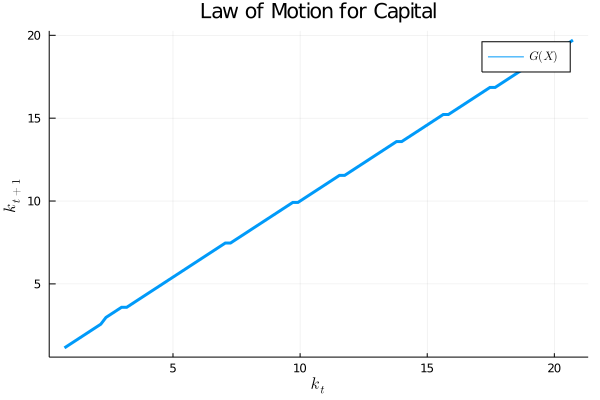

In [8]:
plot(kgrid, k_pol[13,:], title = "Law of Motion for Capital", label = L"G(X)", lw=3)
xlabel!(L"k_t")
ylabel!(L"k_{t+1}")

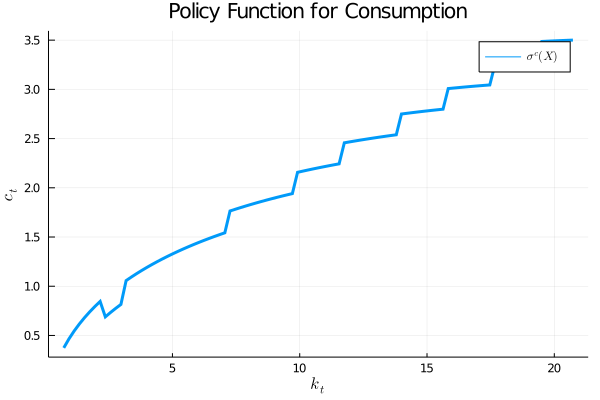

In [9]:
plot(kgrid, c_pol[13,:], title = "Policy Function for Consumption", label = L"\sigma^c(X)", lw=3)
xlabel!(L"k_t")
ylabel!(L"c_t")

---

## Simulations

### RCE Simulation

In [36]:
function simulateRCE(n0, s0, T, n_pol, kgrid, Π, α, δ, β)
    k = zeros(T+1) # capital stock
    n = zeros(Int,T+1) #index of the capital stock
    c = zeros(T)
    y = zeros(T)
    r = zeros(T)
    Q = zeros(T)
    a = zeros(T)
    s = simulate_indices(MarkovChain(Π),T;init=s0)
    
    n[1] = n0
    k[1] = kgrid[n0]
    
    for t in 1:T
        c[t] = c_pol[s[t],n[t]]
        y[t] = A[s[t]]*k[t]^α
        n[t+1] = n_pol[s[t],n[t]] #get the policy rule for the index
        k[t+1] = kgrid[n[t+1]]
        r[t] = A[s[t]]*α*k[t]^(α-1)
        a[t] = (r[t] + 1 - δ)*k[t]
        
        if t < T
            Q[t] = β*Π[s[t],s[t+1]]*(c[t]/c_pol[s[t+1],n[t+1]])*(A[s[t+1]]*α*kgrid[n_pol[s[t+1],n[t+1]]]^(α-1)+1-δ)
        end 
    end

    return k[1:T], c, y, r, Q, a
end

simulateRCE (generic function with 1 method)

### Run the Simulation

In [45]:
T = 10000
n0 = 50
s0 = 13
k_sim, c_sim, y_sim, r_sim, Q_sim, a_sim = simulateRCE(n0, s0, T, n_pol, kgrid, Π, α, δ, β);
k = k_sim[3000:T]
c = c_sim[3000:T]
y = y_sim[3000:T]
r = r_sim[3000:T]
Q = Q_sim[3000:T]
a = a_sim[3000:T];

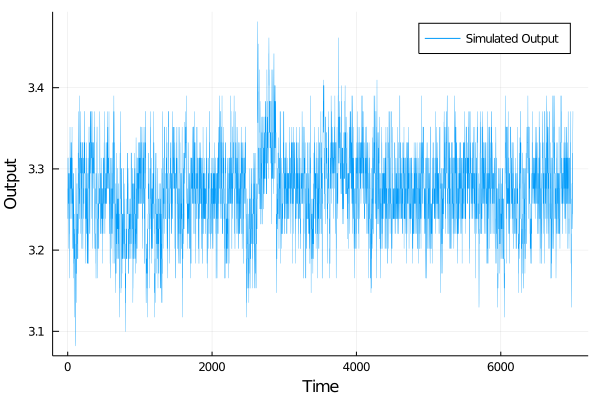

In [39]:
plot(1:length(y), y, label = "Simulated Output", lw=0.3)
xlabel!("Time")
ylabel!("Output")

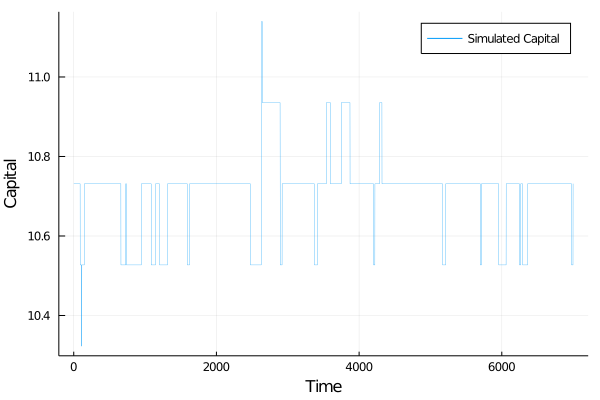

In [40]:
plot(1:length(k), k, label = "Simulated Capital", lw=0.3)
xlabel!("Time")
ylabel!("Capital")

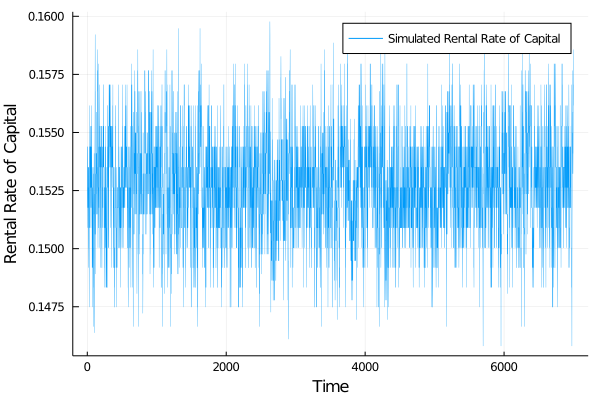

In [41]:
plot(1:length(r), r, label = "Simulated Rental Rate of Capital", lw=0.3)
xlabel!("Time")
ylabel!("Rental Rate of Capital")

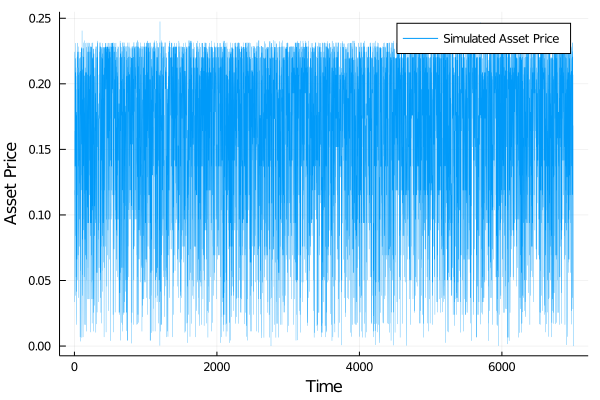

In [42]:
plot(1:length(Q), Q, label = "Simulated Asset Price", lw=0.3)
xlabel!("Time")
ylabel!("Asset Price")

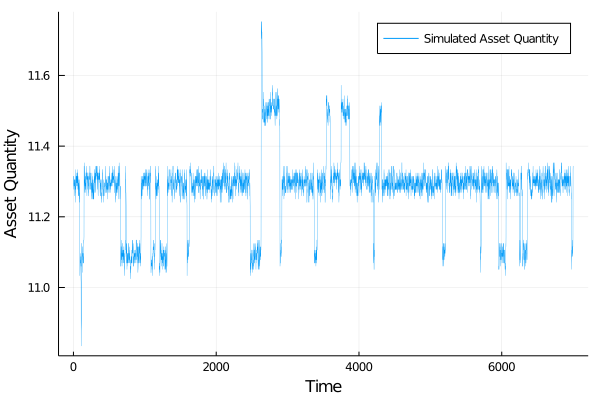

In [43]:
plot(1:length(a), a, label = "Simulated Asset Quantity", lw=0.3)
xlabel!("Time")
ylabel!("Asset Quantity")

---